# DSA RL Training Stages Visualizer

Visualize all training stages from **curve_config.json** and their configuration settings side-by-side.

This notebook shows:
- Configuration summary table for all stages
- Sample images for each stage
- Side-by-side comparison grid
- Parameter progression charts
- Detailed JSON configuration


## Step 1: Setup




In [228]:
! pip install pandas
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("✅ Setup complete!")


✅ Setup complete!


## Step 2: Load Config and Initialize Curve Generator


In [229]:
# Navigate to Experiment3_Refine folder to use its curve generator
import os
import sys
import json
from pathlib import Path

# Get the notebook's directory (should be repo root)
notebook_dir = Path.cwd()
print(f"📂 Current directory: {notebook_dir}")

# Path to Experiment3_Refine
exp3_path = notebook_dir / 'Experiment3_Refine'
if not exp3_path.exists():
    # Try going up one level if we're in a subdirectory
    exp3_path = notebook_dir.parent / 'Experiment3_Refine'
    
if exp3_path.exists():
    # Add Experiment3_Refine/src to path BEFORE importing
    exp3_src = str(exp3_path / 'src')
    if exp3_src not in sys.path:
        sys.path.insert(0, exp3_src)
    print(f"✅ Added to path: {exp3_src}")
    
    # Change to Experiment3_Refine directory
    os.chdir(str(exp3_path))
    print(f"✅ Changed to directory: {os.getcwd()}")
else:
    print(f"⚠️  Experiment3_Refine not found at: {exp3_path}")
    print("   Trying to use Experiment3_Refine/src from current location...")
    # Try adding relative path
    if 'Experiment3_Refine' in str(notebook_dir):
        # We're already in Experiment3_Refine or a subdirectory
        exp3_src = str(Path('src').resolve())
        sys.path.insert(0, exp3_src)
    else:
        exp3_src = str(Path('Experiment3_Refine/src').resolve())
        if Path(exp3_src).exists():
            sys.path.insert(0, exp3_src)

# Import the curve generator from Experiment3_Refine
try:
    from curve_generator import CurveMakerLengthSafe
    print("✅ Successfully imported CurveMakerLengthSafe from Experiment3_Refine")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("   Trying alternative import...")
    # Try importing from the full path
    import importlib.util
    curve_gen_path = Path(exp3_path) / 'src' / 'curve_generator.py'
    if curve_gen_path.exists():
        spec = importlib.util.spec_from_file_location("curve_generator", str(curve_gen_path))
        curve_gen_module = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(curve_gen_module)
        CurveMakerLengthSafe = curve_gen_module.CurveMakerLengthSafe
        print("✅ Loaded CurveMakerLengthSafe from file path")
    else:
        raise ImportError(f"Could not find curve_generator.py at {curve_gen_path}")

# Load the specific configuration file
config_file = 'config/curve_config.json'
print(f"📂 Loading: {config_file}")
if os.path.exists(config_file):
    with open(config_file, 'r') as f:
        config = json.load(f)
    config_path = config_file
    print(f"✅ Loaded config from: {config_path}")
else:
    print(f"⚠️  Config file not found at: {config_file}")
    # Try absolute path
    abs_config = exp3_path / 'config' / 'curve_config.json'
    if abs_config.exists():
        with open(str(abs_config), 'r') as f:
            config = json.load(f)
        config_path = str(abs_config)
        print(f"✅ Loaded config from absolute path: {config_path}")
    else:
        raise FileNotFoundError(f"Could not find config file at {config_file} or {abs_config}")

# Create curve generator instance
# CurveMakerLengthSafe doesn't take config, just dimensions
img_cfg = config.get('image', {})
h = img_cfg.get('height', 128)
w = img_cfg.get('width', 128)
# Create base generator with a seed, but we'll vary it per call
import time
initial_seed = int(time.time()) % 100000
curve_maker_base = CurveMakerLengthSafe(h=h, w=w, seed=initial_seed)
print(f"✅ Created CurveMakerLengthSafe with dimensions: {h}x{w}, seed={initial_seed}")

# Create a wrapper to match the old API (sample_curve method)
class CurveMakerWrapper:
    """Wrapper to adapt CurveMakerLengthSafe to the old CurveMakerFlexible API"""
    def __init__(self, base_maker):
        self.base = base_maker
        self.h = base_maker.h
        self.w = base_maker.w
    
    def sample_curve(self, width_range=(2, 5), noise_prob=0.0, invert_prob=0.0,
                     min_intensity=0.6, max_intensity=None, branches=False,
                     curvature_factor=1.0, allow_self_cross=False, self_cross_prob=0.0,
                     width_variation="none", start_width=None, end_width=None,
                     intensity_variation="none", start_intensity=None, end_intensity=None,
                     background_intensity=None):
        """Adapt old API to new API"""
        import numpy as np
        
        # Map parameters
        thickness_range = width_range
        curvature = curvature_factor
        noise = noise_prob > 0.0
        
        # Generate curve (this creates image with default intensity 0.4-0.8)
        img, mask, pts_list = self.base.sample(
            thickness_range=thickness_range,
            curvature=curvature,
            noise=noise,
            allow_self_cross=allow_self_cross,
            self_cross_prob=self_cross_prob
        )
        
        # Apply intensity based on min_intensity/max_intensity
        # The base generator uses 0.4-0.8, we need to replace with desired range
        max_int = max_intensity if max_intensity is not None else 1.0
        min_int = min_intensity
        
        # Find where the curve is (non-zero pixels in mask)
        curve_mask = mask > 0
        
        if np.any(curve_mask):
            # Use a random intensity in the specified range for the curve
            # This gives variation while respecting the config
            curve_intensity = np.random.uniform(min_int, max_int)
            img[curve_mask] = curve_intensity
        
        # Handle background intensity
        if background_intensity is not None:
            # Set background (where mask is 0) to background_intensity
            img[~curve_mask] = background_intensity
        
        # Handle inversion
        if invert_prob > 0.0 and np.random.random() < invert_prob:
            img = 1.0 - img
        
        # Ensure values are in valid range
        img = np.clip(img, 0.0, 1.0)
        
        # Return in the expected format
        pts = pts_list[0] if isinstance(pts_list, list) and len(pts_list) > 0 else pts_list
        return img, mask, [pts]

curve_maker = CurveMakerWrapper(curve_maker_base)

print(f"✅ Image dimensions: {h}x{w}")
stages = config.get('training_stages', [])
print(f"✅ Found {len(stages)} training stages")

# Verify we have 11 stages
if len(stages) != 11:
    print(f"⚠️  WARNING: Expected 11 stages, but found {len(stages)}")
    print("   Make sure you're loading curve_config.json")
else:
    print("✅ Correct number of stages (11)")

print(f"\n📋 Stages:")
for s in stages:
    if isinstance(s, dict):
        print(f"   Stage {s.get('stage_id')}: {s.get('name')}")
    else:
        print(f"   ⚠️  Warning: Expected dict, got {type(s)}: {s}")


📂 Current directory: /Users/geshvad/Documents/GitHub/DSA-RL-Tracker/Experiment3_Refine
✅ Added to path: /Users/geshvad/Documents/GitHub/DSA-RL-Tracker/Experiment3_Refine/src
✅ Changed to directory: /Users/geshvad/Documents/GitHub/DSA-RL-Tracker/Experiment3_Refine
❌ Import error: cannot import name 'CurveMakerLengthSafe' from 'curve_generator' (/Users/geshvad/Documents/GitHub/DSA-RL-Tracker/Experiment1/src/curve_generator.py)
   Trying alternative import...
✅ Loaded CurveMakerLengthSafe from file path
📂 Loading: config/curve_config.json
✅ Loaded config from: config/curve_config.json
✅ Created CurveMakerLengthSafe with dimensions: 128x128, seed=2770
✅ Image dimensions: 128x128
✅ Found 10 training stages
⚠️  WARNING: Expected 11 stages, but found 10
   Make sure you're loading curve_config.json

📋 Stages:
   Stage 1: Stage1_Foundation
   Stage 2: Stage2_Curvature
   Stage 3: Stage3_ThinPaths
   Stage 4: Stage4_LowIntensity
   Stage 5: Stage5_ThinAndFaint
   Stage 6: Stage6_VeryThinAndVery

### 📊 Configuration Summary

The following stages will be visualized:


In [230]:
# Quick summary of all stages
print("=" * 100)
print("TRAINING STAGES OVERVIEW")
print("=" * 100)
for stage in stages:
    stage_id = stage.get('stage_id', '?')
    stage_name = stage.get('name', f"Stage{stage_id}")
    episodes = stage.get('episodes', 0)
    cg = stage.get('curve_generation', {})
    print(f"\nStage {stage_id}: {stage_name} ({episodes:,} episodes)")
    print(f"  Width: {cg.get('width_range', [0,0])[0]}-{cg.get('width_range', [0,0])[1]} | "
          f"Intensity: {cg.get('min_intensity', 0):.2f}-{cg.get('max_intensity', 0):.2f} | "
          f"Curvature: {cg.get('curvature_factor', 0)}")
    print(f"  Noise: {cg.get('noise_prob', 0)} | Background: {cg.get('background_intensity') if cg.get('background_intensity') is not None else 'null'}")
print("\n" + "=" * 100)


TRAINING STAGES OVERVIEW

Stage 1: Stage1_Foundation (10,000 episodes)
  Width: 3-5 | Intensity: 0.80-1.00 | Curvature: 0.3
  Noise: 0.0 | Background: null

Stage 2: Stage2_Curvature (12,000 episodes)
  Width: 3-5 | Intensity: 0.70-0.90 | Curvature: 0.8
  Noise: 0.0 | Background: null

Stage 3: Stage3_ThinPaths (15,000 episodes)
  Width: 1-3 | Intensity: 0.70-0.90 | Curvature: 0.8
  Noise: 0.0 | Background: null

Stage 4: Stage4_LowIntensity (15,000 episodes)
  Width: 2-5 | Intensity: 0.30-0.50 | Curvature: 0.8
  Noise: 0.0 | Background: null

Stage 5: Stage5_ThinAndFaint (18,000 episodes)
  Width: 1-2 | Intensity: 0.20-0.40 | Curvature: 1.0
  Noise: 0.0 | Background: null

Stage 6: Stage6_VeryThinAndVeryFaint (20,000 episodes)
  Width: 1-1 | Intensity: 0.10-0.30 | Curvature: 1.2
  Noise: 0.0 | Background: null

Stage 7: Stage7_ExtremelyLowIntensity (20,000 episodes)
  Width: 1-3 | Intensity: 0.05-0.10 | Curvature: 1.0
  Noise: 0.0 | Background: null

Stage 8: Stage8_HighBackground (15

## Step 3: Display All Stage Configurations (Summary Table)


In [231]:
# Extract all stage configurations
stages = config.get('training_stages', [])

# Create a summary table
stage_data = []
for stage in stages:
    cg = stage.get('curve_generation', {})
    tr = stage.get('training', {})
    
    stage_data.append({
        'Stage': stage.get('name', f"Stage{stage.get('stage_id', '?')}"),
        'ID': stage.get('stage_id', '?'),
        'Episodes': stage.get('episodes', 0),
        'LR': stage.get('learning_rate', 0),
        'Width': f"{cg.get('width_range', [0,0])[0]}-{cg.get('width_range', [0,0])[1]}",
        'Intensity': f"{cg.get('min_intensity', 0):.2f}-{cg.get('max_intensity', 0):.2f}",
        'Curvature': cg.get('curvature_factor', 0),
        'Noise Prob': cg.get('noise_prob', 0),
        'Invert Prob': cg.get('invert_prob', 0),
        'Background': cg.get('background_intensity') if cg.get('background_intensity') is not None else 'null',
        'Width Var': cg.get('width_variation', 'none'),
        'Intensity Var': cg.get('intensity_variation', 'none'),
        'Self Cross': cg.get('allow_self_cross', False),
        'Self Cross Prob': cg.get('self_cross_prob', 0),
        'Training Noise': tr.get('noise', 0),
        'Tissue': tr.get('tissue', False),
        'Mixed Start': tr.get('mixed_start', False)
    })

df = pd.DataFrame(stage_data)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 15)

print("=" * 120)
print("ALL TRAINING STAGES - CONFIGURATION SUMMARY")
print("=" * 120)
print(df.to_string(index=False))
print("=" * 120)


ALL TRAINING STAGES - CONFIGURATION SUMMARY
                       Stage  ID  Episodes       LR  Width Intensity  Curvature  Noise Prob  Invert Prob Background      Width Var Intensity Var  Self Cross  Self Cross Prob  Training Noise  Tissue  Mixed Start
           Stage1_Foundation   1     10000 0.000100    3-5 0.80-1.00        0.3         0.0          0.5       null           none          none       False              0.0             0.0   False        False
            Stage2_Curvature   2     12000 0.000100    3-5 0.70-0.90        0.8         0.0          0.5       null           none          none       False              0.0             0.0   False        False
            Stage3_ThinPaths   3     15000 0.000005    1-3 0.70-0.90        0.8         0.0          0.5       null           none          none       False              0.0             0.0   False         True
         Stage4_LowIntensity   4     15000 0.000005    2-5 0.30-0.50        0.8         0.0          0.5       n

## Step 4: Visualize Each Stage with Sample Images



VISUALIZING 10 TRAINING STAGES



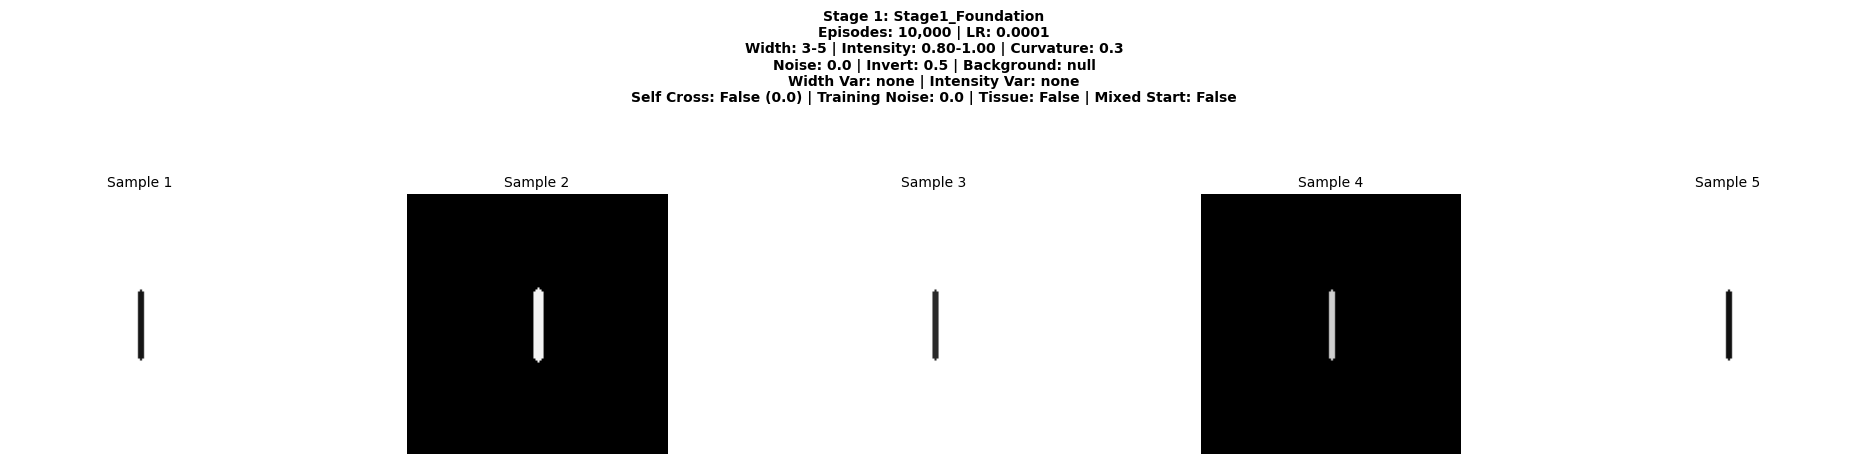


----------------------------------------------------------------------------------------------------



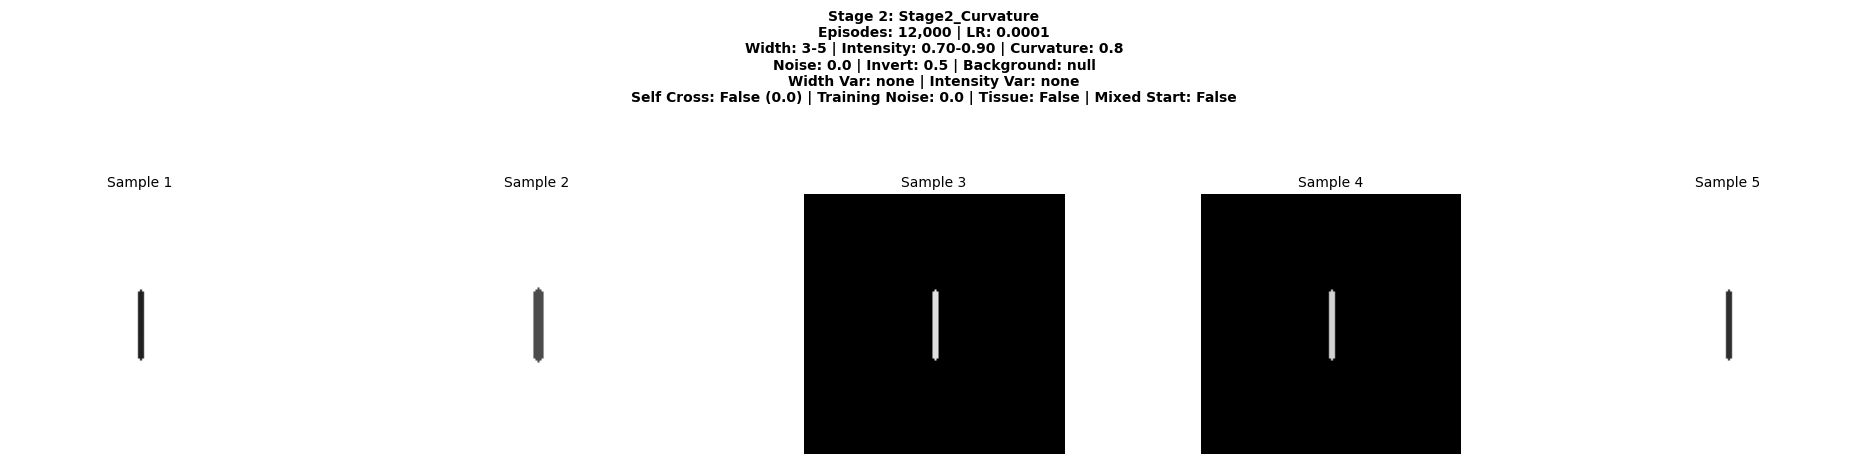


----------------------------------------------------------------------------------------------------



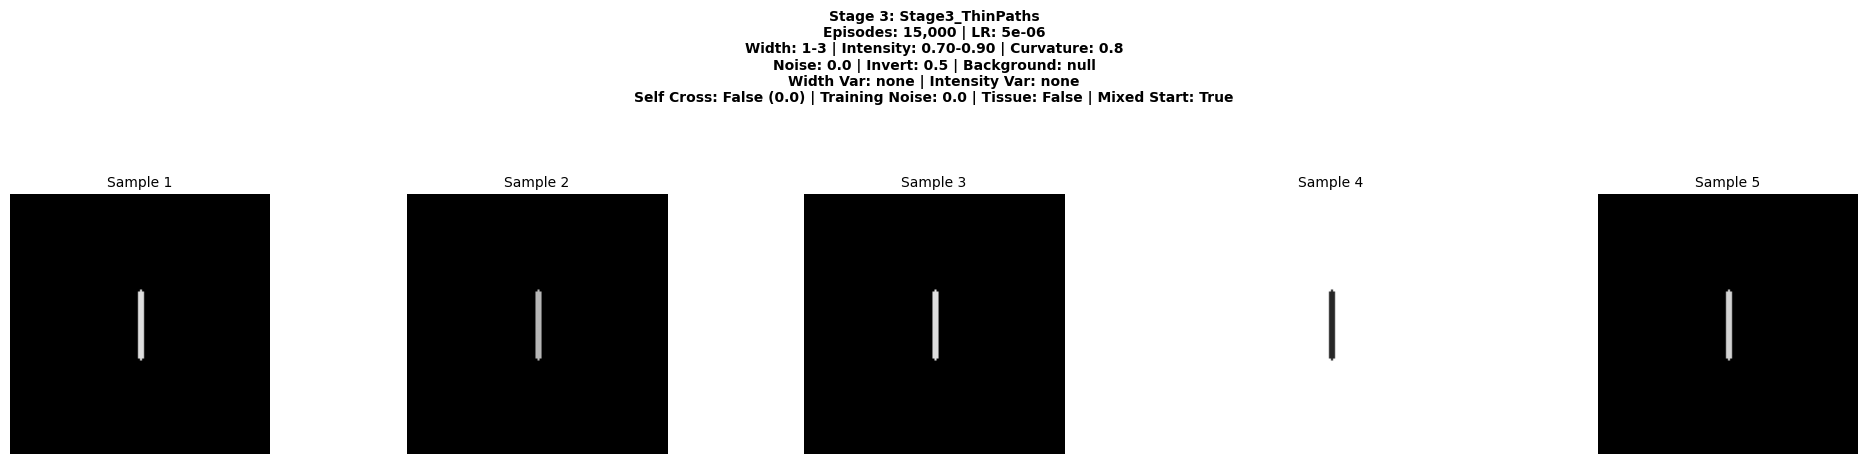


----------------------------------------------------------------------------------------------------



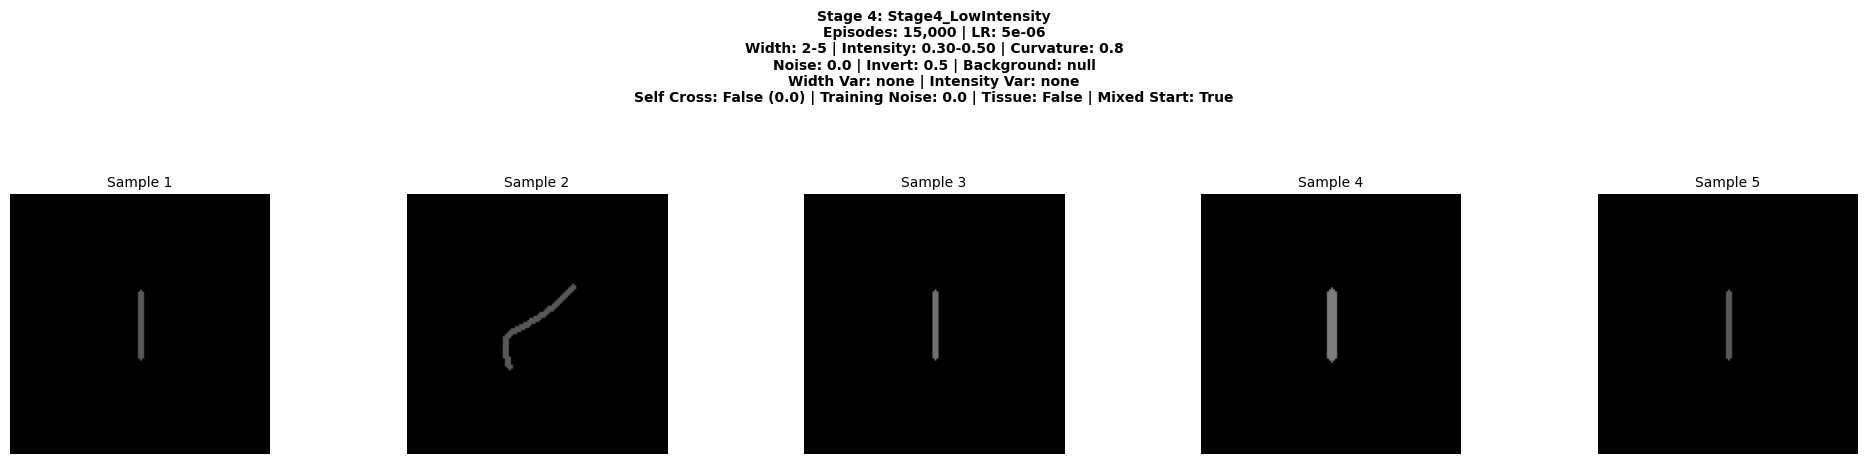


----------------------------------------------------------------------------------------------------



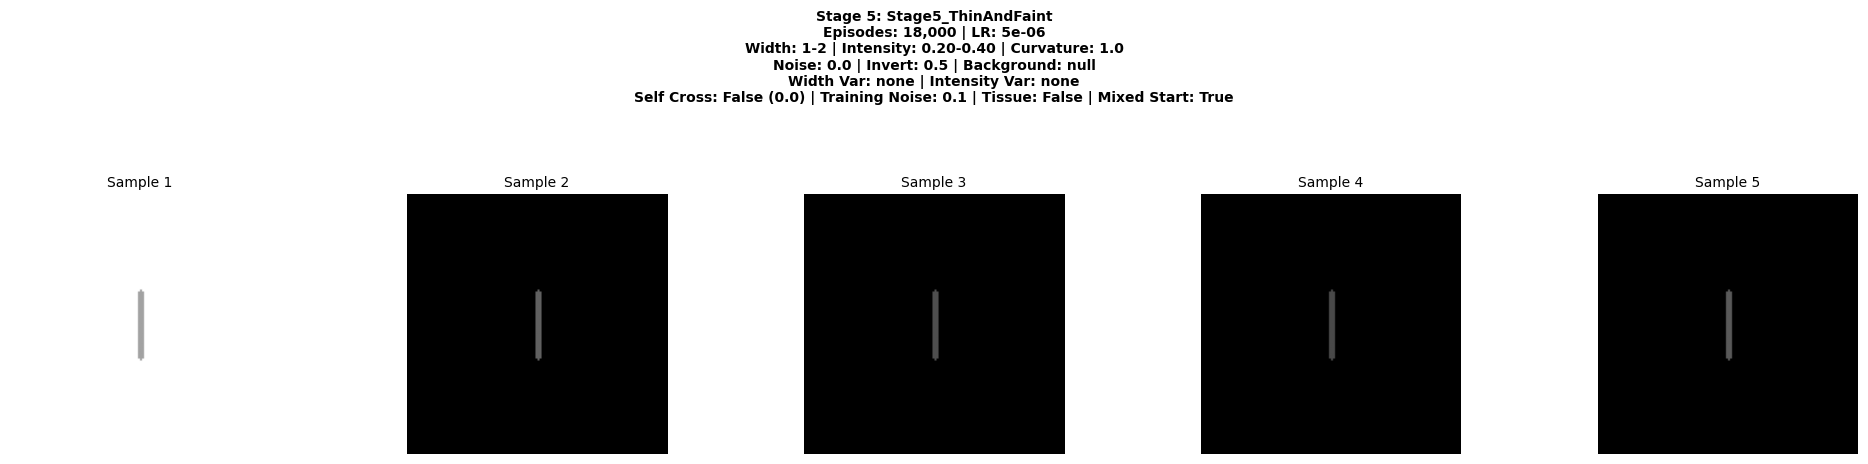


----------------------------------------------------------------------------------------------------



ValueError: low >= high

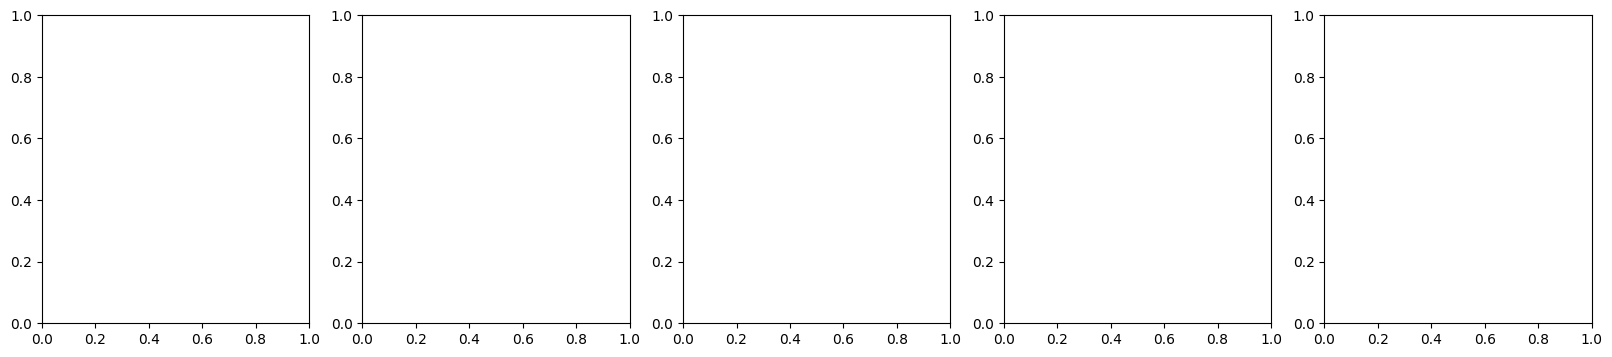

In [232]:
def visualize_stage(stage, n_samples=4):
    """Visualize a single training stage with sample images."""
    stage_id = stage.get('stage_id', '?')
    stage_name = stage.get('name', f"Stage{stage_id}")
    episodes = stage.get('episodes', 0)
    lr = stage.get('learning_rate', 0)
    
    cg = stage.get('curve_generation', {})
    tr = stage.get('training', {})
    
    # Generate sample images
    fig, axes = plt.subplots(1, n_samples, figsize=(4*n_samples, 4))
    
    for i in range(n_samples):
        img, _, _ = curve_maker.sample_curve(
            width_range=tuple(cg.get('width_range', [2, 4])),
            noise_prob=cg.get('noise_prob', 0.0),
            invert_prob=cg.get('invert_prob', 0.0),
            min_intensity=cg.get('min_intensity', 0.6),
            max_intensity=cg.get('max_intensity', 0.8),
            branches=cg.get('branches', False),
            curvature_factor=cg.get('curvature_factor', 1.0),
            allow_self_cross=cg.get('allow_self_cross', False),
            self_cross_prob=cg.get('self_cross_prob', 0.0),
            width_variation=cg.get('width_variation', 'none'),
            intensity_variation=cg.get('intensity_variation', 'none'),
            background_intensity=cg.get('background_intensity', None)
        )
        axes[i].imshow(img, cmap='gray', vmin=0, vmax=1)
        axes[i].axis('off')
        axes[i].set_title(f"Sample {i+1}", fontsize=10)
    
    # Build config summary text
    bg_val = cg.get('background_intensity') if cg.get('background_intensity') is not None else 'null'
    config_text = (
        f"Stage {stage_id}: {stage_name}\n"
        f"Episodes: {episodes:,} | LR: {lr}\n"
        f"Width: {cg.get('width_range', [0,0])[0]}-{cg.get('width_range', [0,0])[1]} | "
        f"Intensity: {cg.get('min_intensity', 0):.2f}-{cg.get('max_intensity', 0):.2f} | "
        f"Curvature: {cg.get('curvature_factor', 0)}\n"
        f"Noise: {cg.get('noise_prob', 0)} | Invert: {cg.get('invert_prob', 0)} | "
        f"Background: {bg_val}\n"
        f"Width Var: {cg.get('width_variation', 'none')} | Intensity Var: {cg.get('intensity_variation', 'none')}\n"
        f"Self Cross: {cg.get('allow_self_cross', False)} ({cg.get('self_cross_prob', 0)}) | "
        f"Training Noise: {tr.get('noise', 0)} | Tissue: {tr.get('tissue', False)} | Mixed Start: {tr.get('mixed_start', False)}"
    )
    
    plt.suptitle(config_text, fontsize=10, fontweight='bold', y=1.15)
    plt.tight_layout()
    plt.show()
    
    return config_text

# Visualize all stages
stages = config.get('training_stages', [])

print(f"\n{'='*100}")
print(f"VISUALIZING {len(stages)} TRAINING STAGES")
print(f"{'='*100}\n")

for stage in stages:
    visualize_stage(stage, n_samples=5)
    print("\n" + "-"*100 + "\n")


## Step 5: Side-by-Side Comparison of All Stages


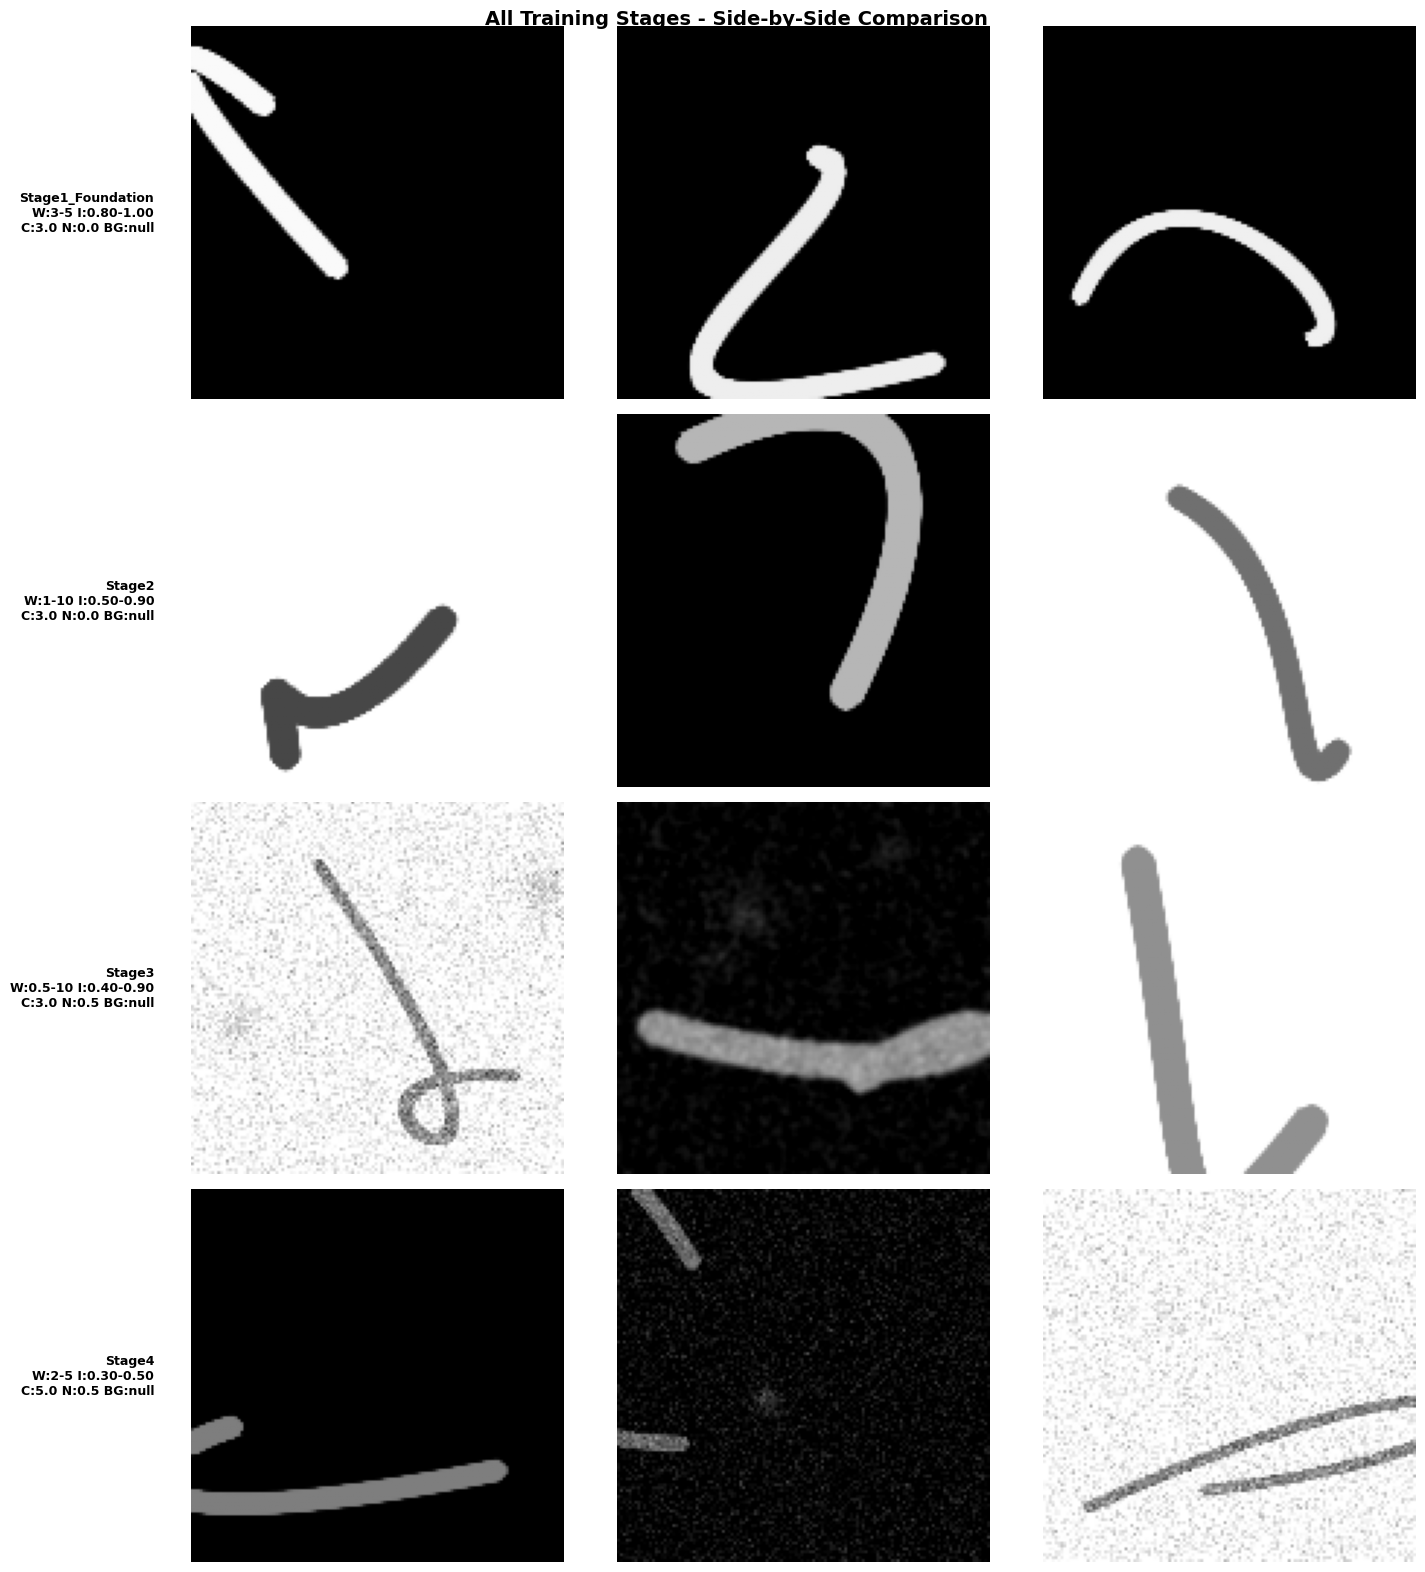

In [140]:
# Create a grid showing all stages side-by-side
fig, axes = plt.subplots(len(stages), 3, figsize=(15, 4*len(stages)))

for idx, stage in enumerate(stages):
    stage_id = stage.get('stage_id', '?')
    stage_name = stage.get('name', f"Stage{stage_id}")
    cg = stage.get('curve_generation', {})
    
    for j in range(3):
        img, _, _ = curve_maker.sample_curve(
            width_range=tuple(cg.get('width_range', [2, 4])),
            noise_prob=cg.get('noise_prob', 0.0),
            invert_prob=cg.get('invert_prob', 0.0),
            min_intensity=cg.get('min_intensity', 0.6),
            max_intensity=cg.get('max_intensity', 0.8),
            branches=cg.get('branches', False),
            curvature_factor=cg.get('curvature_factor', 1.0),
            allow_self_cross=cg.get('allow_self_cross', False),
            self_cross_prob=cg.get('self_cross_prob', 0.0),
            width_variation=cg.get('width_variation', 'none'),
            intensity_variation=cg.get('intensity_variation', 'none'),
            background_intensity=cg.get('background_intensity', None)
        )
        axes[idx, j].imshow(img, cmap='gray', vmin=0, vmax=1)
        axes[idx, j].axis('off')
        
        if j == 0:
            # Add stage info on the left
            bg_val = cg.get('background_intensity') if cg.get('background_intensity') is not None else 'null'
            info = (
                f"{stage_name}\n"
                f"W:{cg.get('width_range', [0,0])[0]}-{cg.get('width_range', [0,0])[1]} "
                f"I:{cg.get('min_intensity', 0):.2f}-{cg.get('max_intensity', 0):.2f}\n"
                f"C:{cg.get('curvature_factor', 0)} "
                f"N:{cg.get('noise_prob', 0)} "
                f"BG:{bg_val}"
            )
            axes[idx, j].text(-0.1, 0.5, info, transform=axes[idx, j].transAxes, 
                            fontsize=9, fontweight='bold', va='center', ha='right')

plt.suptitle("All Training Stages - Side-by-Side Comparison", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## Step 6: Parameter Progression Charts


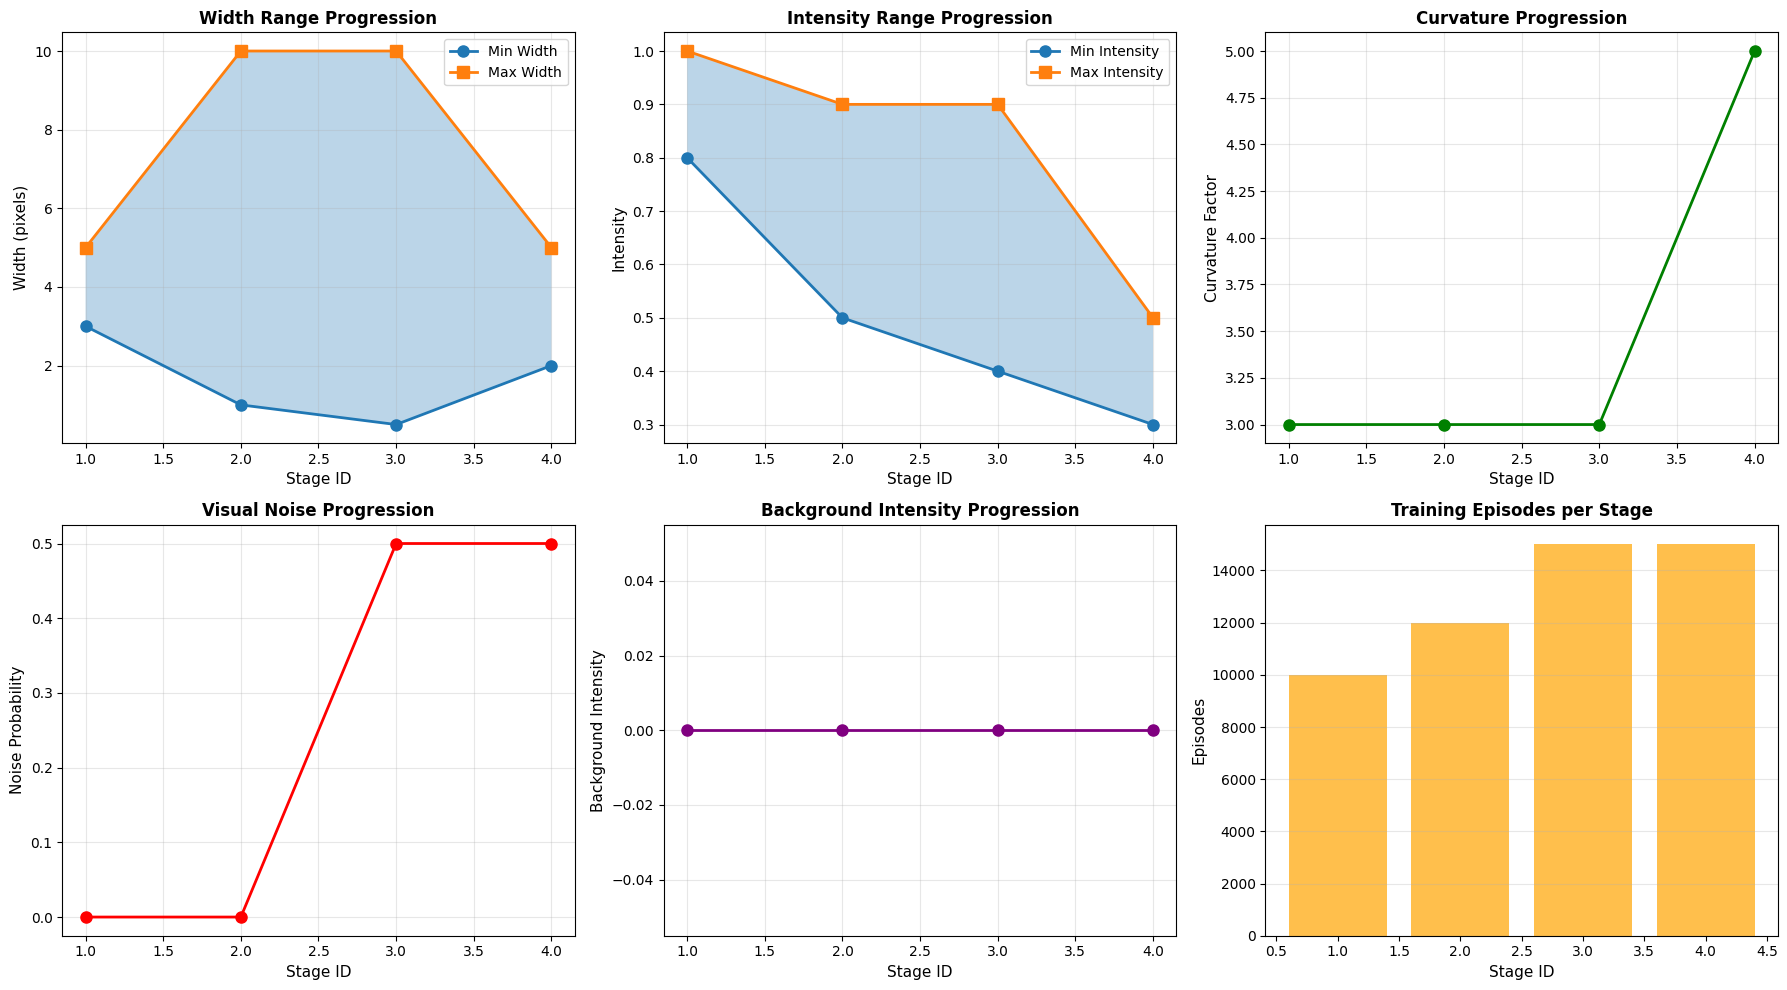

In [141]:
# Extract parameter values for plotting
stage_ids = [s.get('stage_id', 0) for s in stages]
stage_names = [s.get('name', '') for s in stages]

widths_min = [s.get('curve_generation', {}).get('width_range', [0,0])[0] for s in stages]
widths_max = [s.get('curve_generation', {}).get('width_range', [0,0])[1] for s in stages]
intensities_min = [s.get('curve_generation', {}).get('min_intensity', 0) for s in stages]
intensities_max = [s.get('curve_generation', {}).get('max_intensity', 0) for s in stages]
curvatures = [s.get('curve_generation', {}).get('curvature_factor', 0) for s in stages]
noise_probs = [s.get('curve_generation', {}).get('noise_prob', 0) for s in stages]
backgrounds = [s.get('curve_generation', {}).get('background_intensity', 0) if s.get('curve_generation', {}).get('background_intensity') is not None else 0 for s in stages]

# Create progression plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Width progression
axes[0, 0].plot(stage_ids, widths_min, 'o-', label='Min Width', linewidth=2, markersize=8)
axes[0, 0].plot(stage_ids, widths_max, 's-', label='Max Width', linewidth=2, markersize=8)
axes[0, 0].fill_between(stage_ids, widths_min, widths_max, alpha=0.3)
axes[0, 0].set_xlabel('Stage ID', fontsize=11)
axes[0, 0].set_ylabel('Width (pixels)', fontsize=11)
axes[0, 0].set_title('Width Range Progression', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Intensity progression
axes[0, 1].plot(stage_ids, intensities_min, 'o-', label='Min Intensity', linewidth=2, markersize=8)
axes[0, 1].plot(stage_ids, intensities_max, 's-', label='Max Intensity', linewidth=2, markersize=8)
axes[0, 1].fill_between(stage_ids, intensities_min, intensities_max, alpha=0.3)
axes[0, 1].set_xlabel('Stage ID', fontsize=11)
axes[0, 1].set_ylabel('Intensity', fontsize=11)
axes[0, 1].set_title('Intensity Range Progression', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Curvature progression
axes[0, 2].plot(stage_ids, curvatures, 'o-', linewidth=2, markersize=8, color='green')
axes[0, 2].set_xlabel('Stage ID', fontsize=11)
axes[0, 2].set_ylabel('Curvature Factor', fontsize=11)
axes[0, 2].set_title('Curvature Progression', fontsize=12, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# Noise probability progression
axes[1, 0].plot(stage_ids, noise_probs, 'o-', linewidth=2, markersize=8, color='red')
axes[1, 0].set_xlabel('Stage ID', fontsize=11)
axes[1, 0].set_ylabel('Noise Probability', fontsize=11)
axes[1, 0].set_title('Visual Noise Progression', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Background intensity progression
axes[1, 1].plot(stage_ids, backgrounds, 'o-', linewidth=2, markersize=8, color='purple')
axes[1, 1].set_xlabel('Stage ID', fontsize=11)
axes[1, 1].set_ylabel('Background Intensity', fontsize=11)
axes[1, 1].set_title('Background Intensity Progression', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# Episodes per stage
episodes = [s.get('episodes', 0) for s in stages]
axes[1, 2].bar(stage_ids, episodes, color='orange', alpha=0.7)
axes[1, 2].set_xlabel('Stage ID', fontsize=11)
axes[1, 2].set_ylabel('Episodes', fontsize=11)
axes[1, 2].set_title('Training Episodes per Stage', fontsize=12, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## Step 7: Detailed Configuration Display (Full JSON)


In [39]:
# Print detailed configuration for each stage
for stage in stages:
    stage_id = stage.get('stage_id', '?')
    stage_name = stage.get('name', f"Stage{stage_id}")
    
    print(f"\n{'='*100}")
    print(f"STAGE {stage_id}: {stage_name}")
    print(f"{'='*100}")
    print(f"Episodes: {stage.get('episodes', 0):,}")
    print(f"Learning Rate: {stage.get('learning_rate', 0)}")
    print(f"\n--- Curve Generation ---")
    cg = stage.get('curve_generation', {})
    for key, value in sorted(cg.items()):
        print(f"  {key}: {value}")
    print(f"\n--- Training Parameters ---")
    tr = stage.get('training', {})
    for key, value in sorted(tr.items()):
        print(f"  {key}: {value}")
    print()



STAGE 1: Stage1_Foundation
Episodes: 10,000
Learning Rate: 0.0001

--- Curve Generation ---
  allow_self_cross: False
  background_intensity: None
  branches: False
  curvature_factor: 0.3
  end_intensity: None
  end_width: None
  intensity_variation: none
  invert_prob: 0.5
  max_intensity: 1.0
  min_intensity: 0.8
  noise_prob: 0.0
  self_cross_prob: 0.0
  start_intensity: None
  start_width: None
  width_range: [3, 5]
  width_variation: none

--- Training Parameters ---
  mixed_start: False
  noise: 0.0
  strict_stop: False
  tissue: False


STAGE 2: Stage2_Curvature
Episodes: 12,000
Learning Rate: 0.0001

--- Curve Generation ---
  allow_self_cross: False
  background_intensity: None
  branches: False
  curvature_factor: 0.8
  end_intensity: None
  end_width: None
  intensity_variation: none
  invert_prob: 0.5
  max_intensity: 0.9
  min_intensity: 0.7
  noise_prob: 0.0
  self_cross_prob: 0.0
  start_intensity: None
  start_width: None
  width_range: [3, 5]
  width_variation: none
